# Part0: Setup
- Based on https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
- github: https://github.com/khuangaf/Pytorch-Geometric-YooChoose    

### RecSys 2015
- Predict whether there will be a buy event followed by a sequence of clicks
- Predict which item will be bought

# Part1: Torch-Geometric Tutorial

### Create Graph

In [171]:
import torch
from torch_geometric.data import Data

# feature vectors.  element 0 has a 2D feature vector [2,1]
features = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)

# labels for all nodes in our graph
labels = torch.tensor([0, 1, 0, 1], dtype=torch.float)

# edge matrix
edge_index = torch.tensor([[0, 1, 2, 0, 3],  # source nodes
                           [1, 0, 1, 3, 2]], # dest nodes
                          dtype=torch.long)

# Create data object
data = Data(x=features, y=labels, edge_index=edge_index)
data

Data(edge_index=[2, 5], x=[4, 2], y=[4])

In [172]:
data.to_dict()

{'edge_index': tensor([[0, 1, 2, 0, 3],
         [1, 0, 1, 3, 2]]),
 'x': tensor([[ 2.,  1.],
         [ 5.,  6.],
         [ 3.,  7.],
         [12.,  0.]]),
 'y': tensor([0., 1., 0., 1.])}

### Dataset
- 2 types: 
    * InMemoryDataset: data fits into RAM
    * Dataset: can spill onto disk
- Need to implement 4 abstract functions
    * raw_file_names(): It returns a list that shows a list of raw, unprocessed file names. If you only have a file then the returned list should only contain 1 element. In fact, you can simply return an empty list and specify your file later in process().

    * processed_file_names()L Similar to the last function, it also returns a list containing the file names of all the processed data. After process() is called, Usually, the returned list should only have one element, storing the only processed data file name.

    * download()L This function should download the data you are working on to the directory as specified in self.raw_dir. If you don’t need to download data, simply drop in pass in the function.

    * process() This is the most important method of Dataset. You need to gather your data into a list of Data objects. Then, call self.collate() to compute the slices that will be used by the DataLoader object. The following shows an example of the custom dataset fro

### DataLoader
- Uses the dataset defined to feed to the microbatch training
    * loader = DataLoader(dataset, batch_size=512, shuffle=True)

### Message Passing
- how to update current node's embedding
```
Message passing refers to the process by how a node's embedding is updated using the info described here.
			x_i^(k) = fn_update( 
				x_i^(k-1), 
				fn_aggregate( 
					for j in neighbor(i):
						fn_message(
							x_i^(k-1),	# current node i at prev time
							x_j^(k-1),	# neighbor node j at prev time
							edge_i,j
						)
				)  
			)
```

#### Applied to GraphSAGE

In [13]:
# msg function: Each neighboring node embedding is multiplied by a weight matrix, added a bias and passed through an activation function. 
# This can be easily done with torch.nn.Linear.

class SAGEConv():#MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SAGEConv, self).__init__(aggr='max')
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.act = torch.nn.ReLU()
        
    def message(self, x_j):
        # x_j has shape [E, in_channels]

        x_j = self.lin(x_j)
        x_j = self.act(x_j)
      
        return x_j


In [14]:
# update function,  the aggregated message and the current node embedding is aggregated. 
# Then, it is multiplied by another weight matrix and applied another activation function.

class SAGEConv():# MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SAGEConv, self).__init__(aggr='max')
        self.update_lin = torch.nn.Linear(in_channels + out_channels, in_channels, bias=False)
        self.update_act = torch.nn.ReLU()
        
    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]
        
        new_embedding = torch.cat([aggr_out, x], dim=1)
        new_embedding = self.update_lin(new_embedding)
        new_embedding = torch.update_act(new_embedding)
        
        return new_embedding

In [3]:
# Full GraphSAGE Sexamples

import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops

class SAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SAGEConv, self).__init__(aggr='max') #  "Max" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.act = torch.nn.ReLU()
        self.update_lin = torch.nn.Linear(in_channels + out_channels, in_channels, bias=False)
        self.update_act = torch.nn.ReLU()
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        
        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j):
        # x_j has shape [E, in_channels]

        x_j = self.lin(x_j)
        x_j = self.act(x_j)
        
        return x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]


        new_embedding = torch.cat([aggr_out, x], dim=1)
        
        new_embedding = self.update_lin(new_embedding)
        new_embedding = self.update_act(new_embedding)
        
        return new_embedding

# Part2: RecSys 2015 Challenge

### 2.1: Read and Process Data

In [2]:
import pandas as pd
df_clicks = pd.read_csv('/Users/chang/Documents/dev/git/ml/Graph-Machine-Learning/torch-geometric/data/yoochoose-clicks.dat', header=None)
df_clicks.columns = ['session_id', 'timestamp', 'item_id', 'category']
df_clicks.head(2)

/Users/chang/Documents/dev/git/ml/Graph-Machine-Learning/.env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0


In [3]:
from sklearn.preprocessing import LabelEncoder
item_encoder = LabelEncoder()
df_clicks['item_id'] = item_encoder.fit_transform(df_clicks.item_id)
df_clicks.head()

,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,2053,0
1,1,2014-04-07T10:54:09.868Z,2052,0
2,1,2014-04-07T10:54:46.998Z,2054,0
3,1,2014-04-07T10:57:00.306Z,9876,0
4,2,2014-04-07T13:56:37.614Z,19448,0


In [4]:
import pandas as pd
df_buys = pd.read_csv('/Users/chang/Documents/dev/git/ml/Graph-Machine-Learning/torch-geometric/data/yoochoose-buys.dat', header=None)
df_buys.columns = ['session_id', 'timestamp', 'item_id', 'price', 'category']
df_buys.head(2)



,session_id,timestamp,item_id,price,category
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1


In [5]:
# Downsample df_clicks
import numpy as np
sampled_session_id = np.random.choice(df_clicks.session_id.unique(), 1000000, replace=False)
df_clicks = df_clicks.loc[df_clicks.session_id.isin(sampled_session_id)]
df_clicks.nunique()


session_id    1000000
timestamp     3569227
item_id         35640
category          241
dtype: int64

In [156]:
# label: buy if session in df_click is in df_buy.sessionId
df_clicks['label'] = df_clicks.session_id.isin(df_buys.session_id)
df_clicks.head(2)

,session_id,timestamp,item_id,category,label
85,27,2014-04-07T07:40:12.650Z,41308,0,False
86,27,2014-04-07T07:41:13.815Z,41303,0,False


In [150]:
grouped = df_clicks[:100].groupby('session_id')
grouped.head(1)
    

,session_id,timestamp,item_id,category,label
85,27,2014-04-07T07:40:12.650Z,41308,0,False
95,26,2014-04-06T16:42:55.741Z,10087,0,False
144,46,2014-04-03T06:06:58.170Z,28988,0,True
322,102,2014-04-07T03:14:44.923Z,42079,0,False
402,122,2014-04-06T20:45:43.933Z,12849,0,False
428,136,2014-04-01T12:25:23.651Z,45636,0,False
441,143,2014-04-04T19:30:03.512Z,46552,0,False
446,129,2014-04-01T08:37:18.399Z,45755,0,False
512,168,2014-04-03T12:58:36.401Z,44551,0,False
586,201,2014-04-06T11:52:14.508Z,41304,0,False


In [174]:
for session_id, group_df in tqdm(grouped):
    if group_df.shape[0] > 10:
        print(f'{session_id} | {group_df}')

100%|██████████████████| 26/26 [00:00<00:00, 165.91it/s]

324 |       session_id                 timestamp  item_id category  label
994          324  2014-04-04T16:52:11.520Z    44014        0   True
995          324  2014-04-04T16:54:27.956Z    11465        0   True
996          324  2014-04-04T16:58:00.269Z    45561        0   True
997          324  2014-04-04T16:58:45.323Z    44014        0   True
998          324  2014-04-04T17:00:01.946Z    43947        0   True
999          324  2014-04-04T17:00:27.960Z    43631        0   True
1000         324  2014-04-04T17:02:13.997Z    43630        0   True
1001         324  2014-04-04T17:03:23.410Z    43204        0   True
1002         324  2014-04-04T17:05:00.265Z    11469        0   True
1003         324  2014-04-04T17:05:45.023Z    43631        0   True
1004         324  2014-04-04T17:07:37.369Z    43631        0   True
1005         324  2014-04-04T17:12:25.970Z     2443        0   True


### Step2.2 : Construct Torch Dataset
```
we treat each item in a session as a node, and therefore all items in the same session form a graph. To build the dataset, we group the preprocessed data by session_id and iterate over these groups. In each iteration, the item_id in each group are categorically encoded again since for each graph, the node index should count from 0. Thus, we have the following:
```

In [173]:
df_clicks.head(2)

,session_id,timestamp,item_id,category,label
85,27,2014-04-07T07:40:12.650Z,41308,0,False
86,27,2014-04-07T07:41:13.815Z,41303,0,False


In [157]:
import torch
from torch_geometric.data import InMemoryDataset, Data
from tqdm import tqdm

# TWC: Look here!!
df = df_clicks

class YooChooseBinaryDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(YooChooseBinaryDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['yoochoose_click_binary_1M_sess.dataset']
        #return ['/Users/chang/Documents/dev/git/ml/Graph-Machine-Learning/torch-geometric/data/input/yoochoose_click_binary_1M_sess.dataset']

    def download(self):
        pass
    
    def process(self):
        
        data_list = []

        # process by session_id
        grouped = df.groupby('session_id')
        for session_id, group in tqdm(grouped): #group is a DF
            if group.shape[0] < 5:
                continue
                #print(f'{session_id} | {group_df}')
                
            sess_item_id = LabelEncoder().fit_transform(group.item_id)
            group = group.reset_index(drop=True)
            group['sess_item_id'] = sess_item_id

            node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id').item_id.drop_duplicates().values

            node_features = torch.LongTensor(node_features).unsqueeze(1)
            target_nodes = group.sess_item_id.values[1:]
            source_nodes = group.sess_item_id.values[:-1]

            edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
            x = node_features
            
            y_float = 1 if group.label.values[0] else 0
            y = torch.FloatTensor([y_float])
            #y = torch.FloatTensor([group.label.values[0]])
              
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        

In [159]:
dataset = YooChooseBinaryDataset(root='/Users/chang/Documents/dev/git/ml/Graph-Machine-Learning/torch-geometric/data/input2')
import warnings
warnings.filterwarnings('ignore')

Processing...


100%|███████| 1000000/1000000 [05:47<00:00, 2876.24it/s]


PicklingError: Can't pickle <class 'torch_geometric.data.data.Data'>: it's not the same object as torch_geometric.data.data.Data

In [160]:
dataset = dataset.shuffle()
train_dataset = dataset[:800000]
val_dataset = dataset[800000:900000]
test_dataset = dataset[900000:]
len(train_dataset), len(val_dataset), len(test_dataset)

(800000, 100000, 100000)

### Look at datast

In [175]:
print(f'Dataset Attributes:\n\
    type={type(train_dataset)}\n\
    size={train_dataset.len()}\n\
    type(train_dataset[0])={type(train_dataset[0])}\n\n\
    #features={train_dataset.num_features}\n\
    #edge_features={train_dataset.num_edge_features}\n\
    #node_features={train_dataset.num_node_features}\n\
    #classes={train_dataset.num_classes}\n')

Dataset Attributes:
    type=<class '__main__.YooChooseBinaryDataset'>
    size=1000000
    type(train_dataset[0])=<class 'torch_geometric.data.data.Data'>

    #features=1
    #edge_features=0
    #node_features=1
    #classes=2



Number of nodes: 17
Number of edges: 27
Average node degree: 1.59
Contains isolated nodes: False
Contains self-loops: True
Is undirected: False


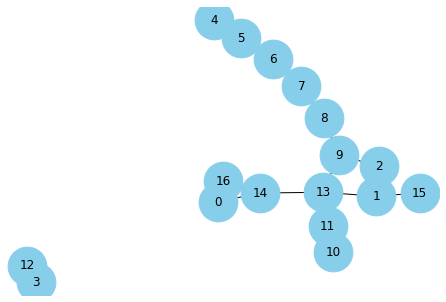

In [166]:
# sample one session
def sample_one_graph(dataset):
    import torch_geometric
    import random
    num_nodes = 0
    one_graph: torch_geometric.data.data.Data = None
    while num_nodes < 10:
        graph_rand_num = random.randint(0, dataset.len()//2)
        #print(f'graph_rand_num={graph_rand_num}')
        one_graph: torch_geometric.data.data.Data = train_dataset[graph_rand_num]
        num_nodes = one_graph.num_nodes
    
    print(f'Number of nodes: {one_graph.num_nodes}')
    print(f'Number of edges: {one_graph.num_edges}')
    print(f'Average node degree: {one_graph.num_edges / one_graph.num_nodes:.2f}')
    #print(f'Number of training nodes: {one_graph.train_mask.sum()}')
    #print(f'Training node label rate: {int(one_graph.train_mask.sum()) / one_graph.num_nodes:.2f}')
    print(f'Contains isolated nodes: {one_graph.contains_isolated_nodes()}')
    print(f'Contains self-loops: {one_graph.contains_self_loops()}')
    print(f'Is undirected: {one_graph.is_undirected()}')
    from torch_geometric.utils import to_networkx

    G = to_networkx(one_graph, to_undirected=True)
    type(G)

    pos = nx.spring_layout(G) # k regulates the distance between nodes
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)

sample_one_graph(train_dataset)

#### Define loader

In [17]:
from torch_geometric.data import DataLoader
batch_size= 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [167]:
num_items = df.item_id.max() +1 
num_items

52739

### Step2.3: Build Graph Neural Network

#### Define Sage Computation Modules

In [19]:
import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops
class SAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SAGEConv, self).__init__(aggr='max') #  "Max" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.act = torch.nn.ReLU()
        self.update_lin = torch.nn.Linear(in_channels + out_channels, in_channels, bias=False)
        self.update_act = torch.nn.ReLU()
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        
        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j):
        # x_j has shape [E, in_channels]

        x_j = self.lin(x_j)
        x_j = self.act(x_j)
        
        return x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]


        new_embedding = torch.cat([aggr_out, x], dim=1)
        
        new_embedding = self.update_lin(new_embedding)
        new_embedding = self.update_act(new_embedding)
        
        return new_embedding
    

#### Define Neural Network

In [176]:
embed_dim = 128
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = SAGEConv(embed_dim, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = SAGEConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = SAGEConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)
        self.item_embedding = torch.nn.Embedding(num_embeddings=df.item_id.max() +1, embedding_dim=embed_dim)
        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()        
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.item_embedding(x)
        x = x.squeeze(1)        

        x = F.relu(self.conv1(x, edge_index))
        
        # https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/pool/topk_pool.html
        # x, edge_index, edge_attr, batch, perm, score[perm]
        x, edge_index, _, batch, _, score = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
     
        x, edge_index, _, batch, _, score = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))

        x, edge_index, _, batch, _, score = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)      
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.sigmoid(self.lin3(x)).squeeze(1)

        return x

### Step2.4: Training

In [178]:
def train():
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        print(type(data))
        print(data)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = crit(output, label)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)
    
device = torch.device('cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.BCELoss()
train_loader = DataLoader(train_dataset, batch_size=batch_size)

num_epochs = 1
for epoch in range(num_epochs):
    train()
    
print('DONE')

<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2842], edge_index=[2, 2476], ptr=[1025], x=[2842, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2999], edge_index=[2, 2637], ptr=[1025], x=[2999, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2827], edge_index=[2, 2436], ptr=[1025], x=[2827, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2876], edge_index=[2, 2455], ptr=[1025], x=[2876, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[3072], edge_index=[2, 2747], ptr=[1025], x=[3072, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2948], edge_index=[2, 2602], ptr=[1025], x=[2948, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2845], edge_index=[2, 2428], ptr=[1025], x=[2845, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2884], edge_index=[2, 2559], ptr=[1025], x=[2884, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch

<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2978], edge_index=[2, 2596], ptr=[1025], x=[2978, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2847], edge_index=[2, 2541], ptr=[1025], x=[2847, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2763], edge_index=[2, 2448], ptr=[1025], x=[2763, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[3048], edge_index=[2, 2757], ptr=[1025], x=[3048, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2857], edge_index=[2, 2537], ptr=[1025], x=[2857, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[3112], edge_index=[2, 2818], ptr=[1025], x=[3112, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2821], edge_index=[2, 2427], ptr=[1025], x=[2821, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch'>
Batch(batch=[2843], edge_index=[2, 2497], ptr=[1025], x=[2843, 1], y=[1024])
<class 'torch_geometric.data.batch.Batch

KeyboardInterrupt: 

### Step2.5: Evaluate

In [29]:
from sklearn.metrics import roc_auc_score
def evaluate(loader):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            pred = model(data).detach().cpu().numpy()

            label = data.y.detach().cpu().numpy()
            predictions.append(pred)
            labels.append(label)

    predictions = np.hstack(predictions)
    labels = np.hstack(labels)
    
    return roc_auc_score(labels, predictions)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

evaluate(test_loader)

0.7315293309613901

In [30]:
# Previously defined
# train_loader = DataLoader(train_dataset, batch_size=batch_size)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

for epoch in range(1):
    loss = train()
    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)    
    test_acc = evaluate(test_loader)
    print('Epoch: {:03d}, Loss: {:.5f}, Train Auc: {:.5f}, Val Auc: {:.5f}, Test Auc: {:.5f}'.
          format(epoch, loss, train_acc, val_acc, test_acc))

    

Epoch: 000, Loss: 0.17595, Train Auc: 0.82499, Val Auc: 0.72343, Test Auc: 0.72170


### Step 2.6: Look at Result

In [34]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('/Users/chang/Documents/dev/git/ml/Graph-Machine-Learning/torch-geometric/results')


In [49]:
# Write to Tensorboard
data_iter = iter(train_loader)
#x=x, edge_index=edge_index, y=y
batch, edge_index, ptr, x, y = data_iter.next()
batch

('batch', tensor([   0,    0,    1,  ..., 1022, 1023, 1023]))

In [44]:
edge_index

('edge_index',
 tensor([[   1,    4,    9,  ..., 2994, 2997, 3001],
         [   0,    9,    3,  ..., 2994, 2996, 3000]]))

In [45]:
ptr


('ptr', tensor([   0,    2,   11,  ..., 2999, 3000, 3002]))

In [46]:
x

('x',
 tensor([[49017],
         [50246],
         [  133],
         ...,
         [49790],
         [12406],
         [20024]]))

In [47]:
y

('y', tensor([0., 0., 0.,  ..., 0., 0., 0.]))